In [1]:
import numpy as np
import pandas as pd
import networkx as nx
# import random
from matplotlib import pyplot as plt
import os
from ipyleaflet import Map, TileLayer, CircleMarker
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.cluster import hierarchy
from sklearn.cluster import KMeans
import contextily as ctx

The given script plot diverse visualisation from a temporal and geographical perspective, including weather and distances

You need the following files correctly located:
* ../Data/2023.csv
* ../Data/* (all the yearly dataset: 2014.csv, ..., 2023.csv)
* ../Data/2023_edges_extended_header.csv
* ../Data/2023_edges_extended.csv

!!! We don't recommend to launch this script. Everything is precomputed and you can already see all the visualisations

In [2]:
dtype_dict = {
    'STARTTIMEMS': np.int64,
    'ENDTIMEMS': np.int64
}
data = pd.read_csv('../Data/2023.csv').dropna(how='any').astype(dtype_dict)
data.head(10)

STARTSTATIONNAME STARTSTATIONARRONDISSEMENT  \
0  Métro Mont-Royal (Utilités publiques / Rivard)      Le Plateau-Mont-Royal   
1                             Rielle / Wellington                     Verdun   
2                        Ste-Catherine / Drummond                Ville-Marie   
3                           Boyer / du Mont-Royal      Le Plateau-Mont-Royal   
4                                 Clark / Ontario                Ville-Marie   
5                            Bourget / St-Jacques               Le Sud-Ouest   
6                     St-Antoine / de la Montagne                Ville-Marie   
7                         de Maisonneuve / Greene                  Westmount   
8                          Marie-Anne / St-Hubert      Le Plateau-Mont-Royal   
9                      Ste-Catherine / St-Laurent                Ville-Marie   

   STARTSTATIONLATITUDE  STARTSTATIONLONGITUDE  \
0             45.524236             -73.581552   
1             45.460156             -73.567001   
2             45.498588             -73.574278   
3             45.527432             -73.579917   
4             45.510625             -73.566903   
5             45.480846             -73.583862   
6             45.495372             -73.568589   
7             45.486971             -73.589293   
8             45.524683             -73.578897   
9             45.509813             -73.563895   

                               ENDSTATIONNAME ENDSTATIONARRONDISSEMENT  \
0                         Chabot / Mont-Royal    Le Plateau-Mont-Royal   
1                         St-Jacques / McGill              Ville-Marie   
2                               Peel / Ottawa             Le Sud-Ouest   
3                de l'Hôtel-de-Ville / Rachel    Le Plateau-Mont-Royal   
4                               Wolfe / Robin              Ville-Marie   
5  Métro Lionel-Groulx (St-Jacques / Atwater)             Le Sud-Ouest   
6                  Ste-Catherine / St-Mathieu              Ville-Marie   
7     Métro Atwater (Atwater / Ste-Catherine)              Ville-Marie   
8                       Marie-Anne / Papineau    Le Plateau-Mont-Royal   
9                    St-André / Ste-Catherine              Ville-Marie   

   ENDSTATIONLATITUDE  ENDSTATIONLONGITUDE    STARTTIMEMS      ENDTIMEMS  
0           45.534134           -73.573524  1698266696468  1698267092113  
1           45.501441           -73.560144  1698270535502  1698271967951  
2           45.494200           -73.559985  1698285705974  1698285992418  
3           45.519897           -73.580106  1698269489932  1698269814383  
4           45.519581           -73.560116  1698270006571  1698270440298  
5           45.483629           -73.579703  1698274953294  1698275119003  
6           45.493833           -73.579142  1698292627511  1698292934248  
7           45.489476           -73.584566  1698268339505  1698268507636  
8           45.531774           -73.572446  1698279430752  1698279675478  
9           45.516427           -73.558112  1698277591355  1698277815637

In [4]:
G = nx.from_pandas_edgelist(data, 'STARTSTATIONNAME', 'ENDSTATIONNAME')

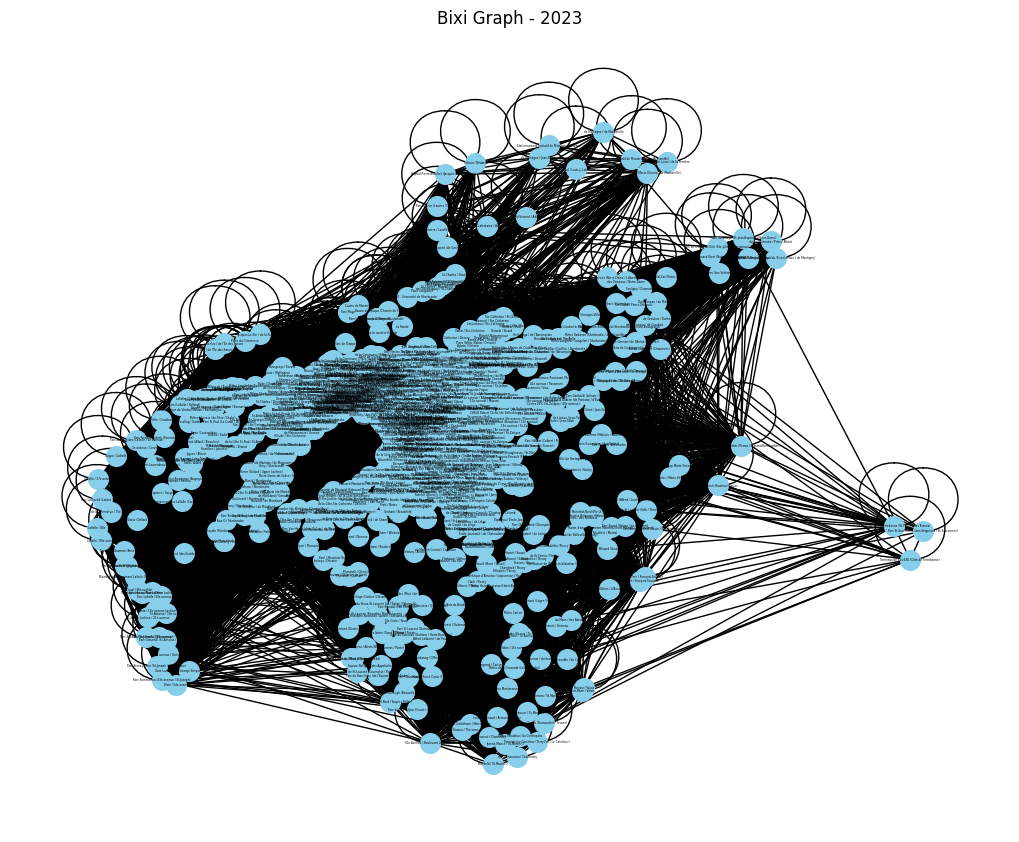

In [5]:
unique_positions_df = data[['STARTSTATIONNAME' , 'STARTSTATIONLATITUDE', 'STARTSTATIONLONGITUDE']].drop_duplicates()

node_positions = {}
nodes_to_remove = []
for node in G.nodes():
    node_data = unique_positions_df.loc[unique_positions_df['STARTSTATIONNAME'] == node]
    if not node_data.empty:
        latitude = node_data.iloc[0]['STARTSTATIONLATITUDE']
        longitude = node_data.iloc[0]['STARTSTATIONLONGITUDE']
        if node == "Smith / Peel": # the coordinate of Smith / Peel is -1/-1 ...
            latitude = 45.500414
            longitude = -73.57371
        node_positions[node] = (latitude, longitude)
    else:
        # handle the case when no coordinate for the node is not found
        nodes_to_remove.append(node)
    
for node in nodes_to_remove:
    G.remove_node(node)

plt.figure(figsize=(10, 8))

nx.draw(G, pos=node_positions, with_labels=True, node_color='skyblue', node_size=200, edge_color='black', linewidths=1, font_size=2)
plt.title('Bixi Graph - 2023')
plt.show()

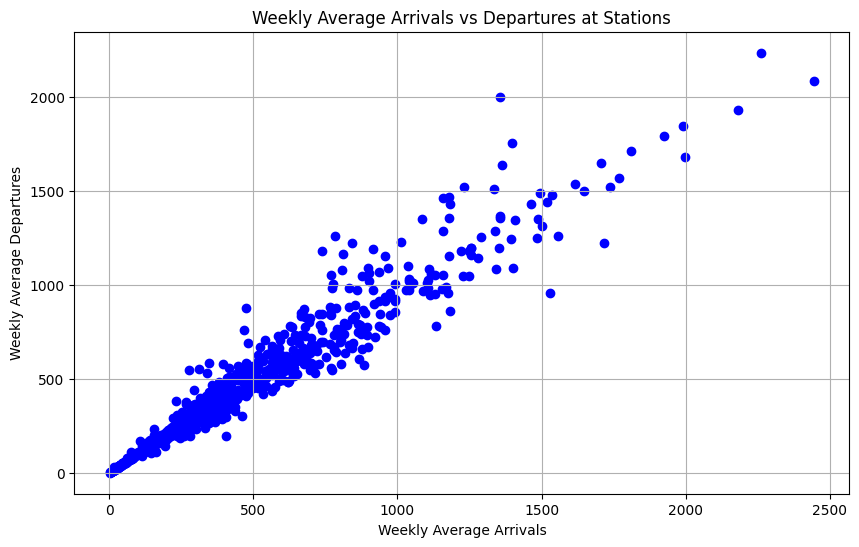

In [7]:
# Convert STARTTIMEMS and ENDTIMEMS to datetime objects
data['STARTTIMEMS'] = pd.to_datetime(data['STARTTIMEMS'], unit='ms')
data['ENDTIMEMS'] = pd.to_datetime(data['ENDTIMEMS'], unit='ms')

# Extract week number from the STARTTIMEMS column
data['Week'] = data['STARTTIMEMS'].dt.isocalendar().week

# Group by STARTSTATIONNAME and Week to calculate weekly average arrivals and departures
grouped = data.groupby(['STARTSTATIONNAME', 'Week']).size().reset_index(name='Arrivals')
grouped = grouped.groupby('STARTSTATIONNAME')['Arrivals'].mean().reset_index(name='AvgArrivals')

# Group by ENDSTATIONNAME and Week to calculate weekly average departures
grouped_departures = data.groupby(['ENDSTATIONNAME', 'Week']).size().reset_index(name='Departures')
grouped_departures = grouped_departures.groupby('ENDSTATIONNAME')['Departures'].mean().reset_index(name='AvgDepartures')

# Merge average arrivals and departures data
grouped = pd.merge(grouped, grouped_departures, left_on='STARTSTATIONNAME', right_on='ENDSTATIONNAME')

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(grouped['AvgArrivals'], grouped['AvgDepartures'], marker='o', color='b')
plt.xlabel('Weekly Average Arrivals')
plt.ylabel('Weekly Average Departures')
plt.title('Weekly Average Arrivals vs Departures at Stations')
plt.grid(True)
plt.show()

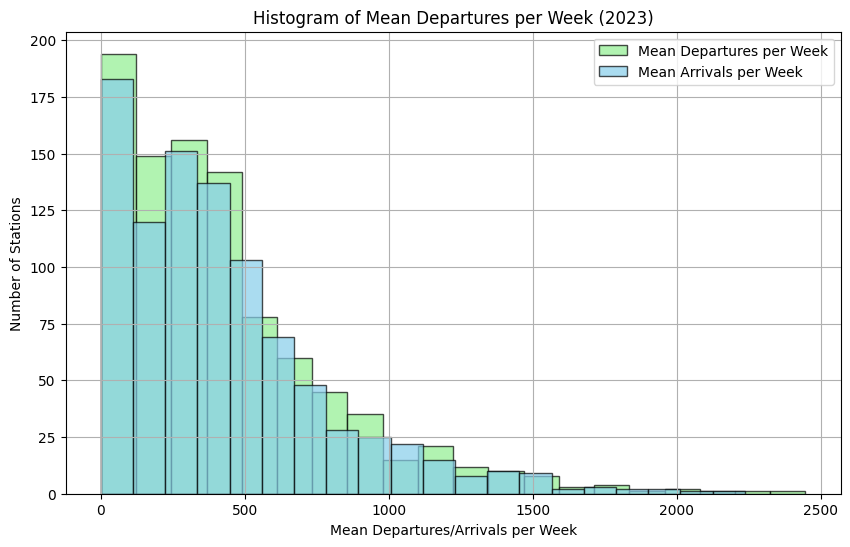

In [52]:
# Convert STARTTIMEMS/ENDTIMEMS to datetime objects
data['STARTTIMEMS'] = pd.to_datetime(data['STARTTIMEMS'], unit='ms')
data['ENDTIMEMS'] = pd.to_datetime(data['ENDTIMEMS'], unit='ms')

# Extract week number from the STARTTIMEMS/ENDTIMEMS column
data['WeekStart'] = data['STARTTIMEMS'].dt.isocalendar().week
data['WeekEnd'] = data['ENDTIMEMS'].dt.isocalendar().week

# Group by STARTSTATIONNAME/ENDSTATIONNAME and Week to compute the count for each station and week
startstation_week_count = data.groupby(['STARTSTATIONNAME', 'WeekStart']).size().reset_index(name='Count')
endstation_week_count = data.groupby(['ENDSTATIONNAME', 'WeekEnd']).size().reset_index(name='Count')

# Calculate the mean count for each station
startstation_mean_count = startstation_week_count.groupby('STARTSTATIONNAME')['Count'].mean().reset_index(name='MeanCount')
endstation_mean_count = endstation_week_count.groupby('ENDSTATIONNAME')['Count'].mean().reset_index(name='MeanCount')

plt.figure(figsize=(10, 6))
num_bins = 20  # Adjust the number of bins as needed
plt.hist(startstation_mean_count['MeanCount'], bins=num_bins, color='lightgreen', edgecolor='black', alpha=0.7, label='Mean Departures per Week')
plt.hist(endstation_mean_count['MeanCount'], bins=num_bins, color='skyblue', edgecolor='black', alpha=0.7, label='Mean Arrivals per Week')
plt.xlabel('Mean Departures/Arrivals per Week')
plt.ylabel('Number of Stations')
plt.title('Histogram of Mean Departures per Week (2023)')
plt.grid(True)
plt.legend()
plt.show()

C:\Users\Chaubi\AppData\Local\Temp\ipykernel_1472\662380285.py:17: DtypeWarning: Columns (4,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(data_folder, filename))


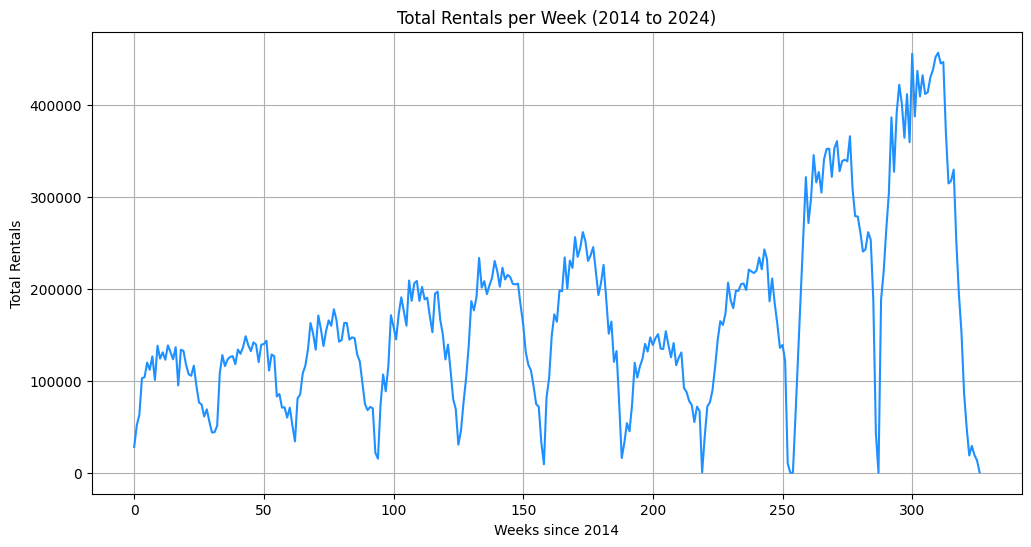

In [56]:
# Directory containing the CSV files
data_folder = '../Data'

# List to store DataFrames from each CSV file
dfs = []

# Iterate over files in the folder
for filename in os.listdir(data_folder):
    # Check if the file is a CSV and its name corresponds to a year from 2014 to 2024
    if filename.endswith('.csv') and filename.split('.')[0].isdigit():
        year = int(filename.split('.')[0])
        if 2014 <= year <= 2024:
            # Read the CSV file into a DataFrame and append it to the list
            df = pd.read_csv(os.path.join(data_folder, filename))
            dfs.append(df)

# Concatenate all DataFrames into a single DataFrame
data = pd.concat(dfs, ignore_index=True)

data['STARTTIMEMS'] = pd.to_datetime(data['STARTTIMEMS'], unit='ms')

# Extract week number from the STARTTIMEMS column
data['Week'] = data['STARTTIMEMS'].dt.isocalendar().week
data['Year'] = data['STARTTIMEMS'].dt.year

# Group by Week and Year to compute the total number of rentals per week
weekly_rentals = data.groupby(['Year', 'Week']).size().reset_index(name='TotalRentals')

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(weekly_rentals.index, weekly_rentals['TotalRentals'], color='#1E90FF', linestyle='-')
plt.xlabel('Weeks since 2014')
plt.ylabel('Total Rentals')
plt.title('Total Rentals per Week (2014 to 2024)')
plt.grid(True)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


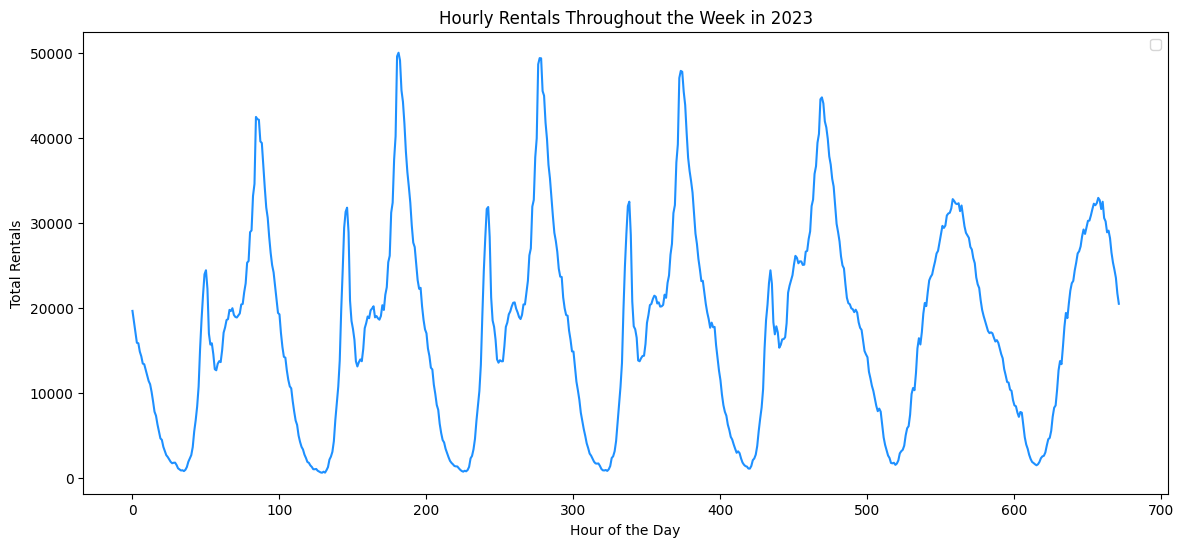

In [66]:
# Convert STARTTIMEMS to datetime objects
data['STARTTIMEMS'] = pd.to_datetime(data['STARTTIMEMS'], unit='ms')

# Extract hour and day of the week information from the STARTTIMEMS column
data['QuarterHour'] = (data['STARTTIMEMS'].dt.hour * 4) + (data['STARTTIMEMS'].dt.minute // 15)
data['DayOfWeek'] = data['STARTTIMEMS'].dt.dayofweek  # Monday=0, Sunday=6

# Group by QuarterHour and Day of the week to compute the total number of rentals for each quarter-hour of each day
quarter_hourly_rentals = data.groupby(['DayOfWeek', 'QuarterHour']).size().reset_index(name='TotalRentals')

# Plotting
plt.figure(figsize=(14, 6))

plt.plot(quarter_hourly_rentals.index, quarter_hourly_rentals['TotalRentals'], color='#1E90FF', linestyle='-')

plt.xlabel('Hour of the Day')
plt.ylabel('Total Rentals')
plt.title('Hourly Rentals Throughout the Week in 2023')
plt.grid(True)
plt.show()

<Figure size 1200x1000 with 0 Axes>

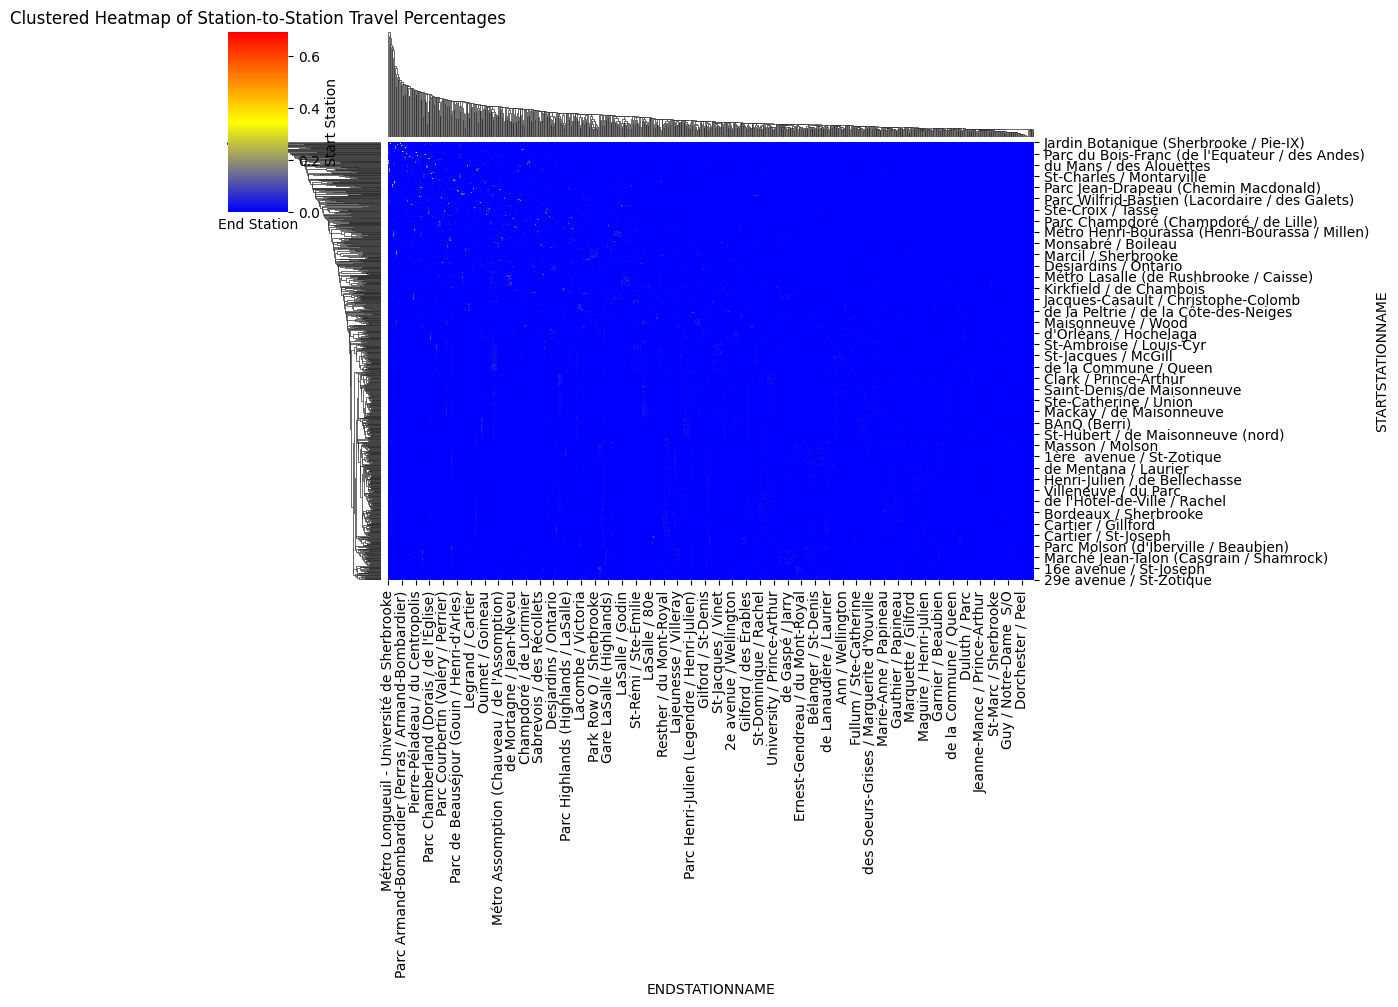

In [6]:
# Compute the total departures from each station
total_departures = data.groupby('STARTSTATIONNAME').size()

# Compute the percentage of departures from each station that arrive at every other station
station_to_station_percentages = pd.pivot_table(data, index='STARTSTATIONNAME', columns='ENDSTATIONNAME', aggfunc='size', fill_value=0) / total_departures.values[:, None]

station_to_station_percentages_log = np.log1p(station_to_station_percentages)

# Hierarchical clustering
row_linkage = hierarchy.linkage(station_to_station_percentages_log.values, method='average')
col_linkage = hierarchy.linkage(station_to_station_percentages_log.values.T, method='average')


colors = ['#0000FF', '#FFFF00', '#FF0000']

# Create a colormap with a smooth transition from blue to yellow to red
cmap = mcolors.LinearSegmentedColormap.from_list('blue_yellow_red', colors)
# Plotting the clustered heatmap
plt.figure(figsize=(12, 10))
sns.clustermap(station_to_station_percentages_log, row_linkage=row_linkage, col_linkage=col_linkage, cmap=cmap, figsize=(12, 10))
plt.title('Clustered Heatmap of Station-to-Station Travel Percentages')
plt.xlabel('End Station')
plt.ylabel('Start Station')
plt.show()

c:\Users\Chaubi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Chaubi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Chaubi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Chaubi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\

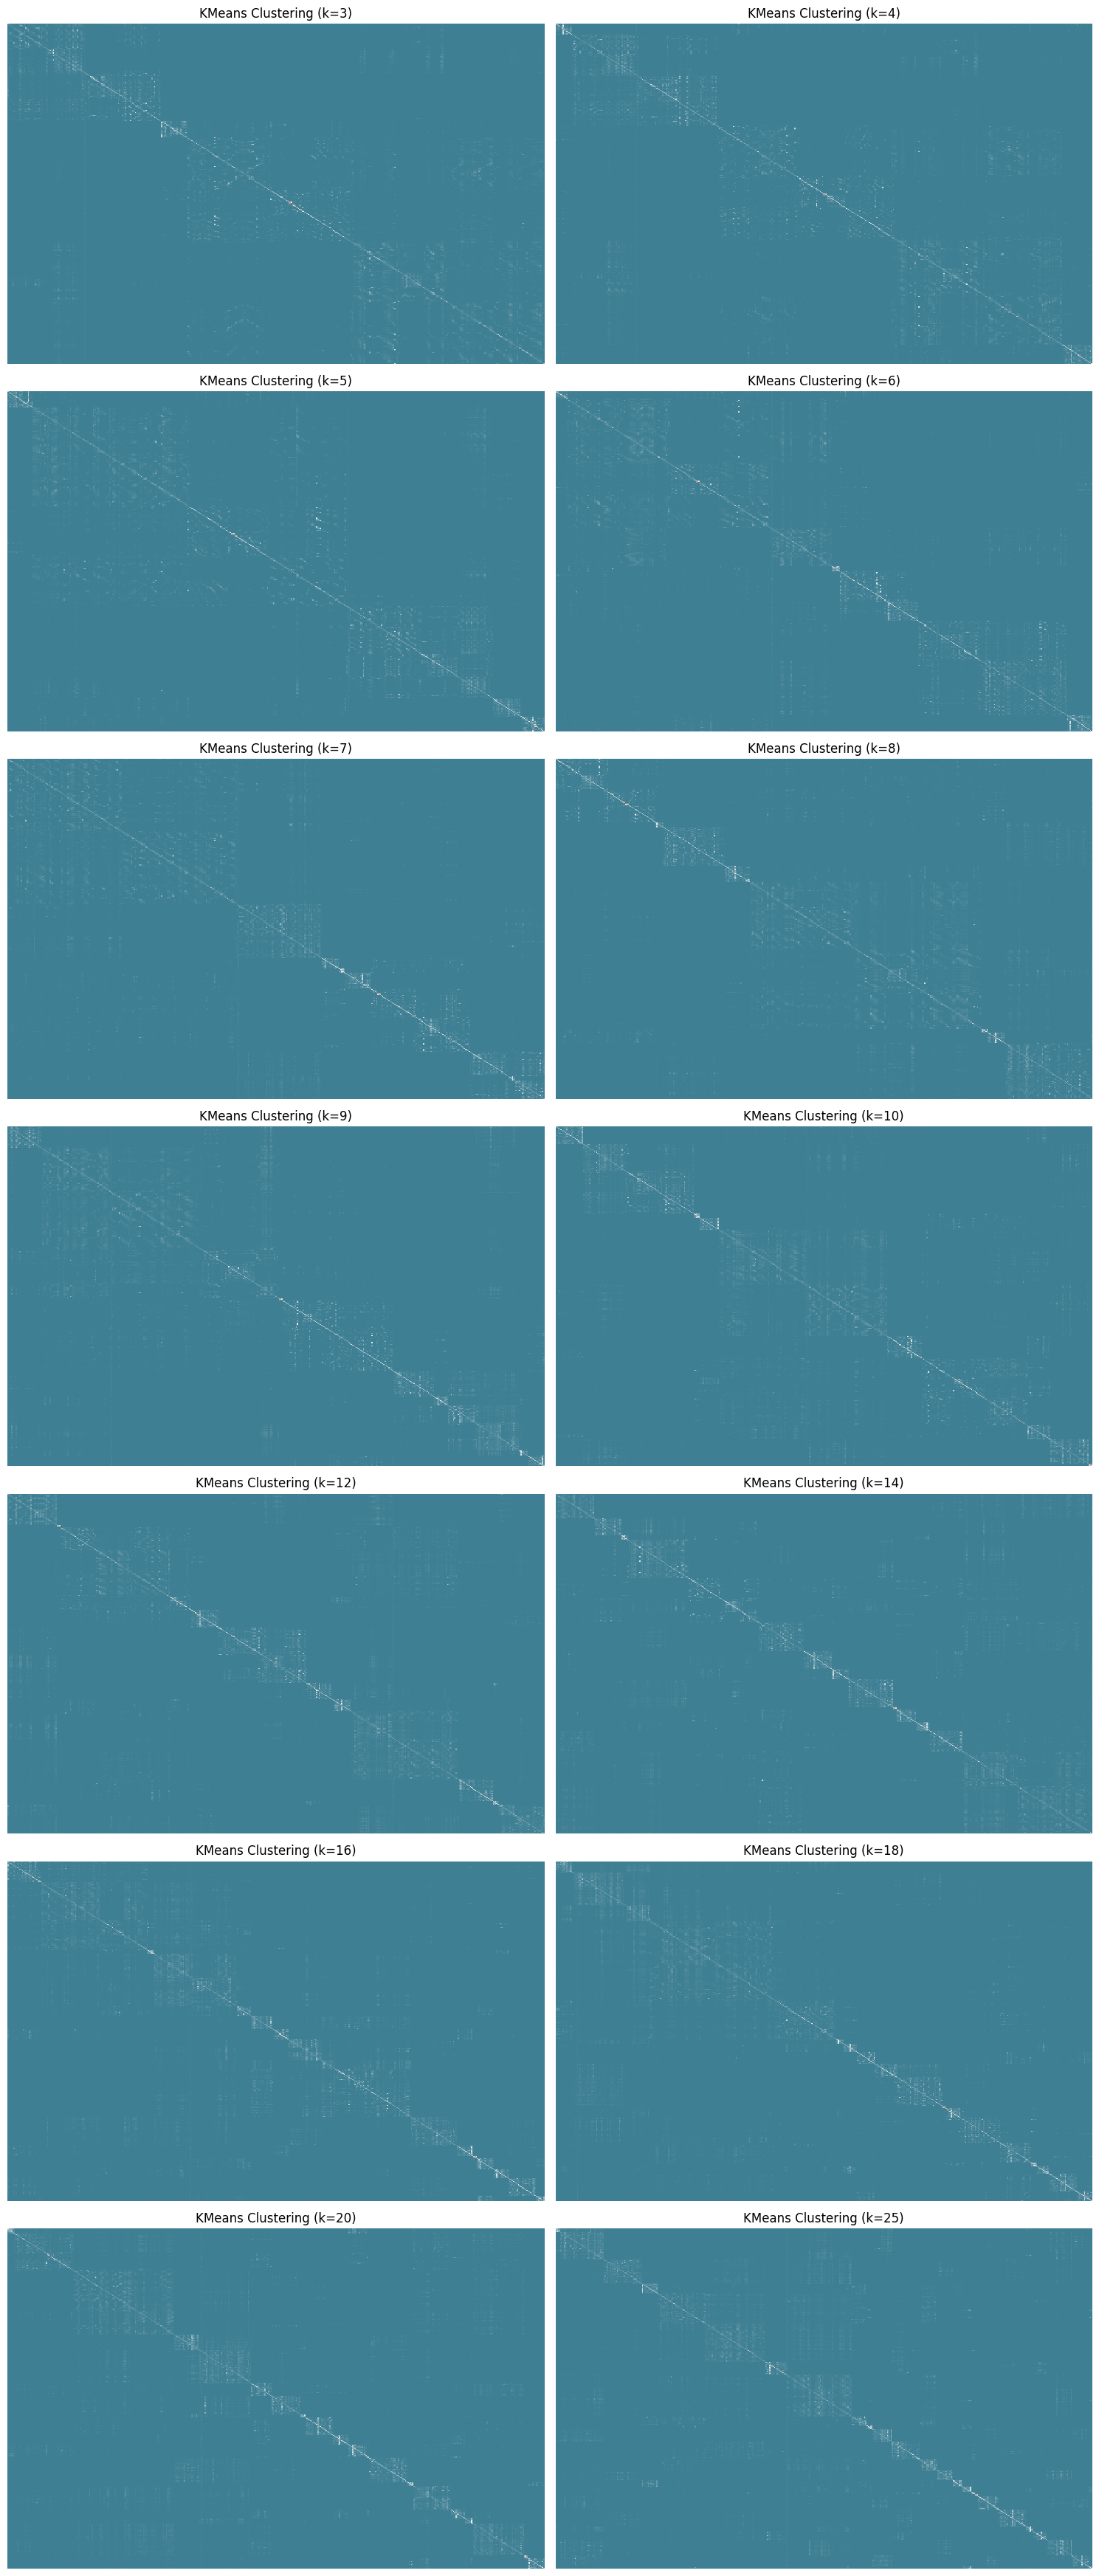

In [41]:

latitude_min = min(data['STARTSTATIONLATITUDE'].min(), data['ENDSTATIONLATITUDE'].min())
latitude_max = max(data['STARTSTATIONLATITUDE'].max(), data['ENDSTATIONLATITUDE'].max())
longitude_min = min(data['STARTSTATIONLONGITUDE'].min(), data['ENDSTATIONLONGITUDE'].min())
longitude_max = max(data['STARTSTATIONLONGITUDE'].max(), data['ENDSTATIONLONGITUDE'].max())

# Define the number of bins
num_bins = 10000

# Define the boundaries of latitude and longitude bins
latitude_bins = np.linspace(latitude_min, latitude_max, num_bins)
longitude_bins = np.linspace(longitude_min, longitude_max, num_bins)

# Assign stations to latitude and longitude squares
data['StartSquare'] = pd.cut(data['STARTSTATIONLATITUDE'], bins=latitude_bins).astype(str) + '_' + pd.cut(data['STARTSTATIONLONGITUDE'], bins=longitude_bins).astype(str)
data['EndSquare'] = pd.cut(data['ENDSTATIONLATITUDE'], bins=latitude_bins).astype(str) + '_' + pd.cut(data['ENDSTATIONLONGITUDE'], bins=longitude_bins).astype(str)

# Compute the total departures from each square
total_departures = data.groupby(['StartSquare']).size()

# Compute the percentage of departures between stations within each square
station_to_station_percentages = pd.pivot_table(data, index=['StartSquare'], columns='EndSquare', aggfunc='size', fill_value=0) / total_departures.values[:, None]
station_to_station_percentages_log = np.log1p(station_to_station_percentages)

# Perform KMeans clustering
k_values = [3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18, 20, 25]  # You can adjust this list with the values of k you want to test
num_plots = len(k_values)

# Create subplots with 2 plots per row
num_rows = (num_plots + 1) // 2
fig, axes = plt.subplots(num_rows, 2, figsize=(15, 5 * num_rows))

custom_palette = sns.diverging_palette(220, 20, as_cmap=True)

for i, k in enumerate(k_values):
    row = i // 2
    col = i % 2
    # Perform KMeans clustering
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(station_to_station_percentages_log)
    sorted_idx = np.argsort(clusters)
    sorted_columns = station_to_station_percentages_log.columns[sorted_idx]
    sorted_rows = station_to_station_percentages_log.index[sorted_idx]
    sorted_percentages = station_to_station_percentages_log.reindex(index=sorted_rows, columns=sorted_columns)
    
    # Plot the clustered heatmap
    sns.heatmap(sorted_percentages, cmap=custom_palette, ax=axes[row, col], cbar=False)
    axes[row, col].set_title(f'KMeans Clustering (k={k})')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

In [3]:
data['STARTTIMEMS'] = pd.to_datetime(data['STARTTIMEMS'], unit='ms')
data['ENDTIMEMS'] = pd.to_datetime(data['ENDTIMEMS'], unit='ms')
data = data[data['STARTTIMEMS'].dt.dayofweek < 5]  

# Create a map for each hour between 5 am and 11 pm
for hour in range(5, 24):
    # Filter data for the current hour
    departure_data = data[data['STARTTIMEMS'].dt.hour == hour]
    arrival_data = data[data['ENDTIMEMS'].dt.hour == hour]

    # Compute sum of arrivals and departures for the current hour
    departure_counts = departure_data.groupby(['STARTSTATIONLATITUDE', 'STARTSTATIONLONGITUDE', 'STARTSTATIONNAME']).size()
    arrival_counts = arrival_data.groupby(['ENDSTATIONLATITUDE', 'ENDSTATIONLONGITUDE', 'ENDSTATIONNAME']).size()

    # Create a DataFrame with the counts and calculate the difference
    counts_df = pd.DataFrame({
        'Departures': departure_counts,
        'Arrivals': arrival_counts
    }).fillna(0)

    counts_df['Difference'] = counts_df['Arrivals'] - counts_df['Departures']
    
    scaler = MinMaxScaler(feature_range=(5, 20))  # Define the desired range for the radius
    counts_df['Radius'] = scaler.fit_transform(counts_df[['Departures', 'Arrivals']].max(axis=1).values.reshape(-1, 1)).flatten()

    # Create a map centered around Montreal
    montreal_center = [45.5017, -73.5673]
    mymap = Map(center=montreal_center, zoom=12)
    
    # Add OpenTopoMap tiles to the map
    opentopomap_layer = TileLayer(url="https://{s}.tile.opentopomap.org/{z}/{x}/{y}.png", attribution="Map data: &copy; OpenTopoMap")
    mymap.add_layer(opentopomap_layer)

    # Add markers for each station based on the difference
    for (lat, lon, name), row in counts_df.iterrows():
        color = 'red' if row['Difference'] < 0 else 'green'
        radius = int(row['Radius'])
        mymap.add_layer(CircleMarker(location=(lat, lon), radius=radius, color=color, fill_opacity=0.3))

    # Display the map
    print(f"Map for {hour}:00")
    display(mymap)


Map for 5:00


Map(center=[45.5017, -73.5673], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'z…

Map for 6:00


Map(center=[45.5017, -73.5673], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'z…

Map for 7:00


Map(center=[45.5017, -73.5673], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'z…

Map for 8:00


Map(center=[45.5017, -73.5673], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'z…

Map for 9:00


Map(center=[45.5017, -73.5673], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'z…

Map for 10:00


Map(center=[45.5017, -73.5673], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'z…

Map for 11:00


Map(center=[45.5017, -73.5673], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'z…

Map for 12:00


Map(center=[45.5017, -73.5673], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'z…

Map for 13:00


Map(center=[45.5017, -73.5673], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'z…

Map for 14:00


Map(center=[45.5017, -73.5673], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'z…

Map for 15:00


Map(center=[45.5017, -73.5673], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'z…

Map for 16:00


Map(center=[45.5017, -73.5673], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'z…

Map for 17:00


Map(center=[45.5017, -73.5673], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'z…

Map for 18:00


Map(center=[45.5017, -73.5673], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'z…

Map for 19:00


Map(center=[45.5017, -73.5673], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'z…

Map for 20:00


Map(center=[45.5017, -73.5673], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'z…

Map for 21:00


Map(center=[45.5017, -73.5673], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'z…

Map for 22:00


Map(center=[45.5017, -73.5673], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'z…

Map for 23:00


Map(center=[45.5017, -73.5673], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'z…

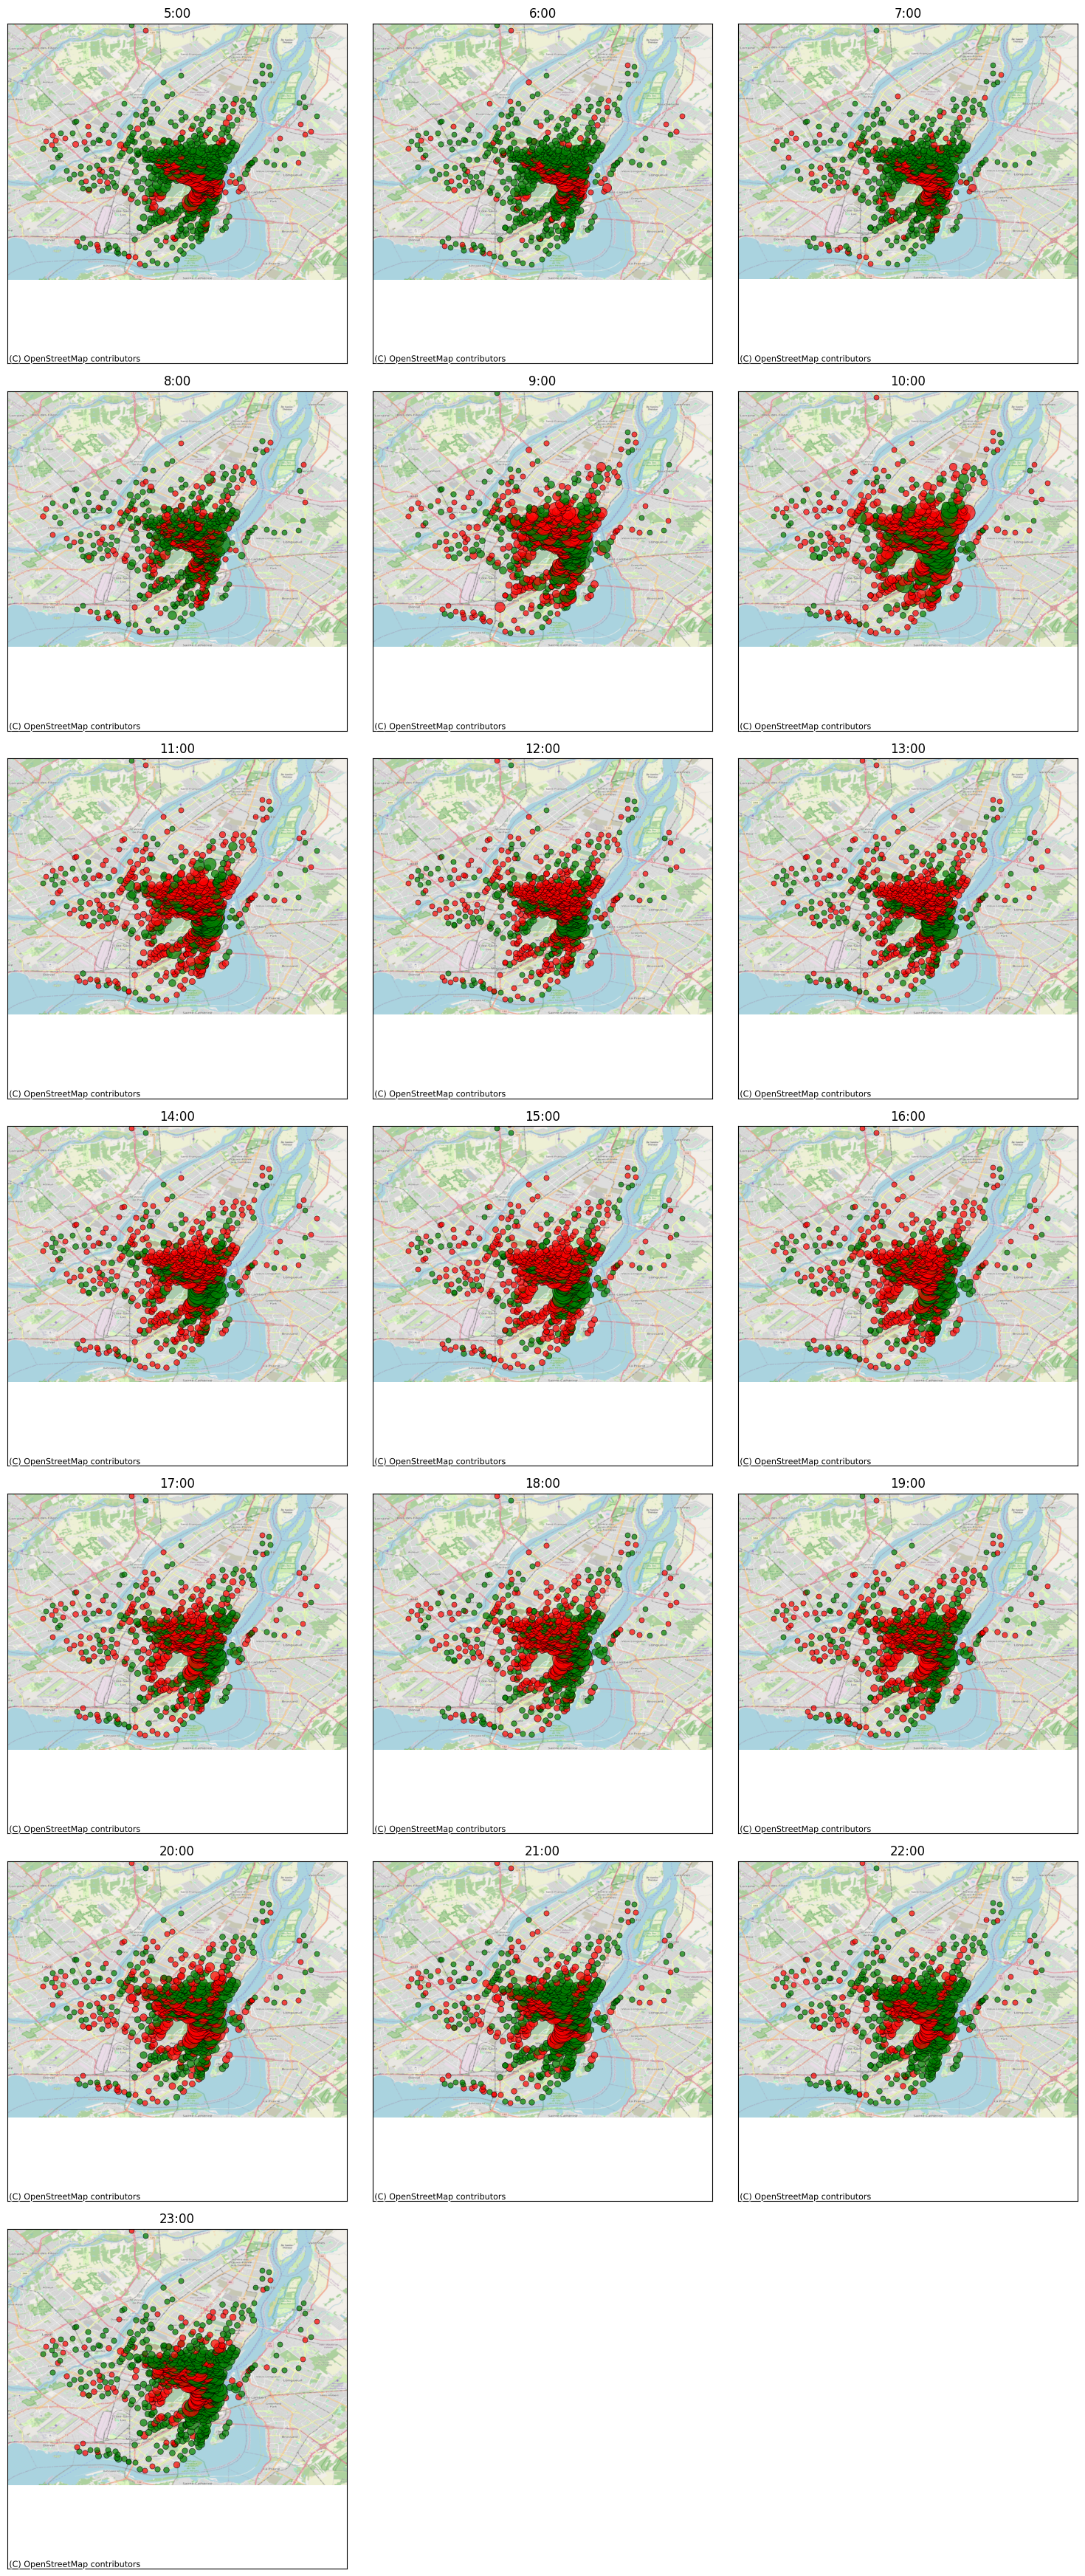

In [12]:
data['STARTTIMEMS'] = pd.to_datetime(data['STARTTIMEMS'], unit='ms')
data['ENDTIMEMS'] = pd.to_datetime(data['ENDTIMEMS'], unit='ms')
data = data[data['STARTTIMEMS'].dt.dayofweek < 5] 

hours = range(5, 24)
num_maps = len(hours)
num_cols = 3
num_rows = (num_maps + num_cols - 1) // num_cols  # Calculate number of rows needed

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

for idx, hour in enumerate(hours):
    ax = axes[idx // num_cols, idx % num_cols]

    # Filter data for the current hour
    departure_data = data[data['STARTTIMEMS'].dt.hour == hour]
    arrival_data = data[data['ENDTIMEMS'].dt.hour == hour]

    # Compute sum of arrivals and departures for the current hour
    departure_counts = departure_data.groupby(['STARTSTATIONLATITUDE', 'STARTSTATIONLONGITUDE', 'STARTSTATIONNAME']).size()
    arrival_counts = arrival_data.groupby(['ENDSTATIONLATITUDE', 'ENDSTATIONLONGITUDE', 'ENDSTATIONNAME']).size()

    # Create a DataFrame with the counts and calculate the difference
    counts_df = pd.DataFrame({
        'Departures': departure_counts,
        'Arrivals': arrival_counts
    }).fillna(0)

    counts_df['Difference'] = counts_df['Arrivals'] - counts_df['Departures']
    
    scaler = MinMaxScaler(feature_range=(5, 20))  # Define the desired range for the radius
    counts_df['Radius'] = scaler.fit_transform(counts_df[['Departures', 'Arrivals']].max(axis=1).values.reshape(-1, 1)).flatten()

    # Plot the data points on the map
    for (lat, lon, name), row in counts_df.iterrows():
        color = 'red' if row['Difference'] < 0 else 'green'
        size = row['Radius']
        ax.scatter(lon, lat, s=size**2, color=color, alpha=0.7, edgecolor='k', linewidth=0.5)

    # Add the OpenStreetMap tiles
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=12, crs='EPSG:4326')

    ax.set_xlim(-73.8, -73.4)
    ax.set_ylim(45.3, 45.7)
    ax.set_title(f"{hour}:00")
    ax.set_xticks([])
    ax.set_yticks([])

# Hide any unused subplots
for idx in range(num_maps, num_rows * num_cols):
    fig.delaxes(axes.flatten()[idx])

plt.tight_layout()
plt.show()


In [5]:
with open('../Data/2023_edges_extended_header.csv', 'r') as file:
    columns = file.readline().strip().split(',') 
df_edges = pd.read_csv('../Data/2023_edges_extended.csv', header=None)
df_edges.columns = columns

# Convert STARTTIMEMS to datetime objects
df_edges['start_date:DATETIME'] = pd.to_datetime(df_edges['start_date:DATETIME'])
df_edges['end_date:DATETIME'] = pd.to_datetime(df_edges['end_date:DATETIME'])

df_edges.head()

:START_ID  starttimems:int  startlatitude:float  startlongitude:float  \
0          0    1698266696468            45.524236            -73.581552   
1          1    1698270535502            45.460156            -73.567001   
2          2    1698285705974            45.498588            -73.574278   
3          3    1698269489932            45.527432            -73.579917   
4          4    1698270006571            45.510625            -73.566903   

   endtimems:int  endlatitude:float  endlongitude:float  :END_ID  \
0  1698267092113          45.534134          -73.573524      505   
1  1698271967951          45.501441          -73.560144      297   
2  1698285992418          45.494200          -73.559985      467   
3  1698269814383          45.519897          -73.580106      420   
4  1698270440298          45.519581          -73.560116     1630   

      start_date:DATETIME       end_date:DATETIME  ...        period_string  \
0 2023-10-25 20:44:56.468 2023-10-25 20:51:32.113  ...  2023-10-25 20:00:00   
1 2023-10-25 21:48:55.502 2023-10-25 22:12:47.951  ...  2023-10-25 21:00:00   
2 2023-10-26 02:01:45.974 2023-10-26 02:06:32.418  ...  2023-10-26 02:00:00   
3 2023-10-25 21:31:29.932 2023-10-25 21:36:54.383  ...  2023-10-25 21:00:00   
4 2023-10-25 21:40:06.571 2023-10-25 21:47:20.298  ...  2023-10-25 21:00:00   

             conditions  temperature  wind_speed  good_weather  origin_id  \
0  Généralement nuageux         18.0        30.0           1.0          0   
1  Généralement nuageux         18.0        15.0           1.0          1   
2  Généralement nuageux         16.0        15.0           1.0          2   
3  Généralement nuageux         18.0        15.0           1.0          3   
4  Généralement nuageux         18.0        15.0           1.0          4   

  destination_id distance_ors  duration_ors  distance_haversine  
0            505      1370.14        277.86         1265.884488  
1            297      6308.18       1301.75         4621.718528  
2            467      1373.10        283.17         1216.274132  
3            420      1217.88        245.38          838.028295  
4           1630      1504.53        320.23         1127.610237  

[5 rows x 26 columns]

In [4]:
conditions = df_edges.groupby(['conditions']).size().reset_index(name='n')
pd.set_option('display.max_colwidth', None)
conditions

conditions        n
0                              Alternance de soleil et de nuages   876898
1             Alternance de soleil et de nuages. Risque d'orages     2853
2                                                        Averses   105432
3                                              Averses ou orages    41328
4                                             Averses ou orages.   148330
5                                       Averses. Risque d'orages   134095
6                                                         Bruine     5877
7                                           Bruine intermittente    10195
8                                                        Couvert    11898
9                                                         Dégagé  1763674
10                                                    Ensoleillé  1332580
11                                                  Faible neige     1972
12                                    Faible neige intermittente     6764
13      Faible neige intermittente. Risque de bruine verglaçante     7922
14                                                         Fumée    37647
15                                       Généralement ensoleillé   909379
16                                          Généralement nuageux  1061597
17            Généralement nuageux. Risque de bruine verglaçante      400
18                                                         Neige     3812
19                                                Neige fondante      895
20                                           Neige intermittente      735
21               Neige intermittente mêlée de bruine verglaçante     3072
22                                          Neige mêlée de pluie      241
23            Neige mêlée de pluie. Risque de pluie verglaçante      4753
24                                           Neige parfois forte     1682
25                           Neige. Risque de pluie verglaçante      2125
26                                                       Nuageux   404517
27                         Nuageux. Risque de bruine verglaçante       48
28                                         Partiellement nuageux   982132
29                                                         Pluie    92920
30                                           Pluie intermittente    90685
31                            Pluie intermittente mêlée de neige       85
32                                 Pluie intermittente ou bruine     1828
33   Pluie intermittente ou bruine. Risque de bruine verglaçante     8035
34                          Pluie intermittente. Risque d'orages     9934
35                                           Pluie parfois forte    58273
36                          Pluie parfois forte. Risque d'orages    14077
37                                        Pluie. Risque d'orages     4759
38                                         Possibilité d'averses  1708788
39                                Possibilité d'averses de neige    59672
40                    Possibilité d'averses de neige ou de pluie     8588
41  Possibilité d'averses de neige. Risque de bruine verglaçante    10944
42                    Possibilité d'averses de pluie ou de neige     3525
43                        Possibilité d'averses. Risque d'orages   377626
44               Possibilité d'averses. Risque d'orages violents    83629
45           Possibilité d'averses. Risque de pluie verglaçante       982
46                                              Quelques averses   219493
47                                     Quelques averses de neige      124
48                                    Quelques averses ou orages     9083
49                                   Quelques averses ou orages.    26550
50                             Quelques averses. Risque d'orages    60908
51                                               Quelques nuages  1019785

In [4]:
# Filter for travels between 6 AM and 9 PM
filtered_df = df_edges[(df_edges['start_date:DATETIME'].dt.hour >= 6) & (df_edges['start_date:DATETIME'].dt.hour <= 21)]

# Group by month, day, and weather, then count the number of travels
weather_counts = filtered_df.groupby(['month', 'day', 'good_weather']).size().reset_index(name='Count')

# Determine the majority weather for each day
majority_weather = weather_counts.loc[weather_counts.groupby(['month', 'day'])['Count'].idxmax()]

# Merge the majority weather back to the filtered dataframe
daily_rentals = filtered_df.groupby(['month', 'day']).size().reset_index(name='TotalRentals')
daily_rentals = pd.merge(daily_rentals, majority_weather[['month', 'day', 'good_weather']], on=['month', 'day'], how='left')

daily_rentals['date'] = pd.to_datetime(daily_rentals[['month', 'day']].assign(year=2023))

# Ensure temperature data has the same date format and calculate mean temperature per day
df_edges['date'] = df_edges['start_date:DATETIME'].dt.normalize()
df_daily_temp = df_edges.groupby('date')['temperature'].mean().reset_index(name='mean_temperature')

# Merge rental and daily mean temperature data on the date column
df_merged = pd.merge(daily_rentals, df_daily_temp, on='date', how='left')

# Plot the TotalRentals and mean temperature on the same plot
fig, ax1 = plt.subplots(figsize=(25, 6))

# Plot TotalRentals as a line plot on the primary y-axis
ax1.plot(df_merged['date'], df_merged['TotalRentals'], color='b', label='Total Rentals')
ax1.set_xlabel('Date')
ax1.set_ylabel('Total Rentals', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Highlight bad weather days with grey background
for idx, row in df_merged.iterrows():
    if not row['good_weather']:
        ax1.axvspan(row['date'] - pd.Timedelta(hours=12), row['date'] + pd.Timedelta(hours=12), color='grey', alpha=0.3)

# Create a secondary y-axis to plot the mean temperature
ax2 = ax1.twinx()
ax2.plot(df_merged['date'], df_merged['mean_temperature'], color='r', label='Mean Temperature')
ax2.set_ylabel('Mean Temperature (°C)', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Add legends
fig.tight_layout()  # Adjust layout to accommodate both y-axis labels
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Set plot title
plt.title('Total Rentals and Mean Temperature per Day with Weather Indication')

# Show plot
plt.show()

NameError: name 'df_edges' is not defined

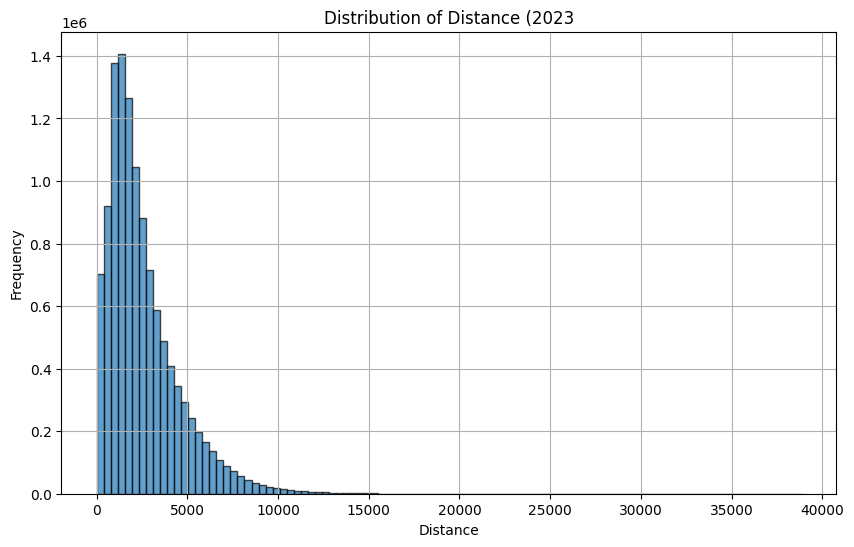

In [9]:
plt.figure(figsize=(10, 6))

plt.hist(df_edges['distance_ors'], bins=100, edgecolor='k', alpha=0.7)

plt.title('Distribution of Distance (2023)')
plt.xlabel('Distance')
plt.ylabel('Frequency')

plt.grid(True)
plt.show()

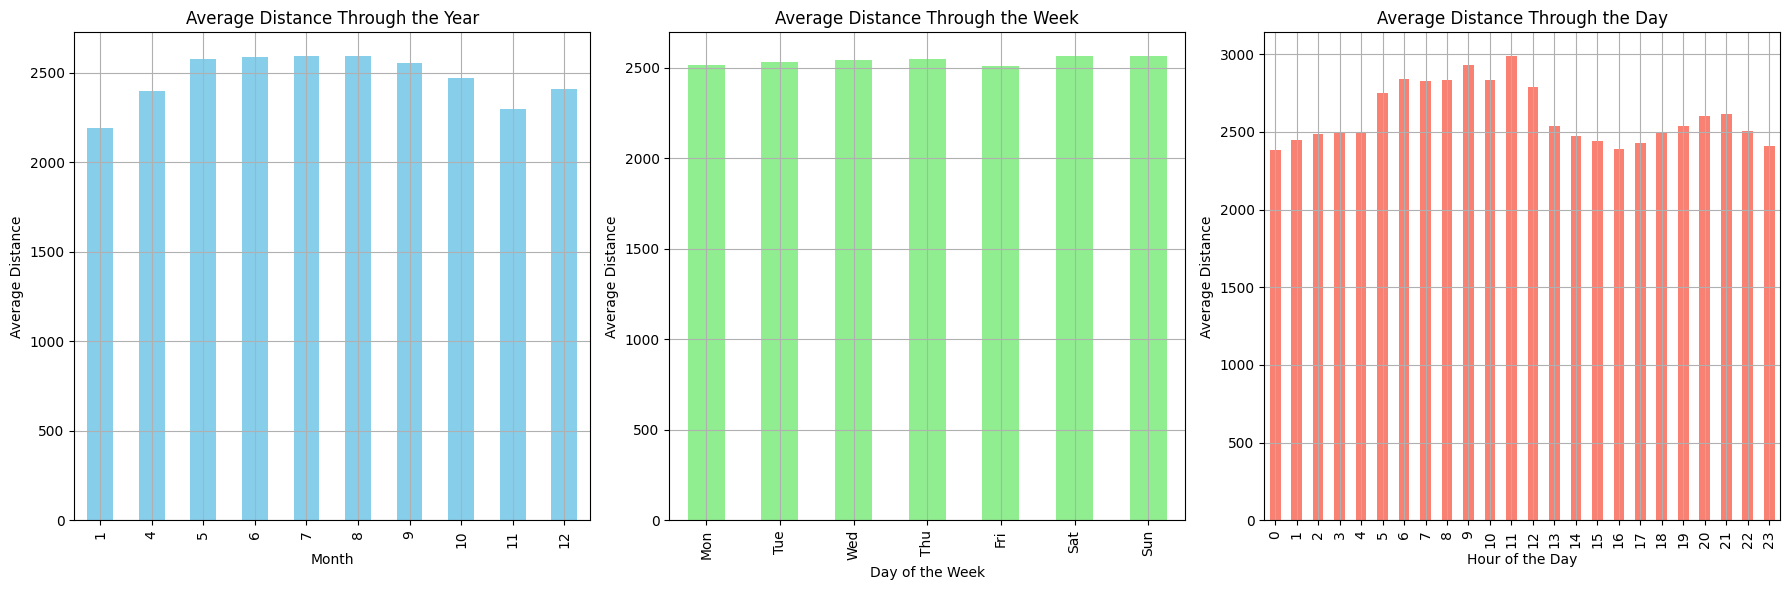

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot distance through the year
df_edges.groupby('month')['distance_ors'].mean().plot(kind='bar', color='skyblue', ax=axes[0])
axes[0].set_title('Average Distance Through the Year')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Average Distance')
axes[0].grid(True)

# Plot distance through the week
df_edges.groupby('dayofWeek')['distance_ors'].mean().plot(kind='bar', color='lightgreen', ax=axes[1])
axes[1].set_title('Average Distance Through the Week')
axes[1].set_xlabel('Day of the Week')
axes[1].set_ylabel('Average Distance')
axes[1].set_xticks(range(7))
axes[1].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
axes[1].grid(True)

# Plot distance through the day
df_edges.groupby('hour')['distance_ors'].mean().plot(kind='bar', color='salmon', ax=axes[2])
axes[2].set_title('Average Distance Through the Day')
axes[2].set_xlabel('Hour of the Day')
axes[2].set_ylabel('Average Distance')
axes[2].grid(True)

plt.tight_layout()
plt.show()